In [1]:
import numpy as np
import os
from skimage.transform import resize
from imageio import imread
import datetime
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix 

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
train_doc = np.random.permutation(open(r'C:\Users\Machine Learning\MMAI\894\train.csv').readlines())
val_doc = np.random.permutation(open(r'C:\Users\Machine Learning\MMAI\894\val.csv').readlines())
batch_size = 64

### DataPreprocessing

In [4]:
def cropResize(image, y, z):
    h, w = image.shape
    
    # if smaller image crop at center for 120x120
    if w == 160:
        image = image[:120, 20:140]

    # resize every image
    return resize(image, (y,z))

In [5]:
def normalizeImage(image):
    # applying normalization
    return image/255.0

In [6]:
def preprocessImage(image, y, z):
    return normalizeImage(cropResize(image, y, z))

In [7]:
def getBatchData(source_path, t, batch, batch_size, img_tensor):
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    img_idx = img_tensor[0]
    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images used for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes

            # separate preprocessImage function is defined for cropping, resizing and normalizing images
            batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z)
            batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z)
            batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z)

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels

### Generator

In [8]:
def generator(source_path, folder_list, batch_size, img_tensor):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)
        
        # write the code for the remaining data points which are left after full batches
        # checking if any remaining batches are there or not
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(folder_list)%batch_size
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = r'C:\Users\Machine Learning\MMAI\894\train'
val_path = r'C:\Users\Machine Learning\MMAI\894\val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [10]:
def getImgTensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 100, 100, 3]

# define image tensor size
img_tensor = getImgTensor(20)
print ('# img_tensor =', img_tensor)

# img_tensor = [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]


In [11]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size, img_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size, img_tensor)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  C:\Users\Machine Learning\MMAI\894\train ; batch size = 64
(64, 20, 100, 100, 3)
Source path =  C:\Users\Machine Learning\MMAI\894\val ; batch size = 64
(64, 20, 100, 100, 3)


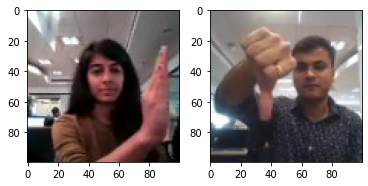

In [12]:
# plot generated sample images
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_val_batch_data[16,10,:,:,:])   
ax[1].imshow(sample_val_batch_data[25,10,:,:,:])
plt.show()

In [13]:
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### Callback

In [14]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

callbacks_list = [LR]

### Base Model

In [15]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

In [22]:
n_frames = 16
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)
  
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model1 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d1")

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model1.summary())

model1_history = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 12, 96, 96, 16)    6016      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 6, 48, 48, 16)    0         
 3D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 6, 48, 48, 16)    64        
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 4, 46, 46, 32)     13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 4, 23, 23, 32)    0         
 3D)                                                             
                                                          

### Plot Model

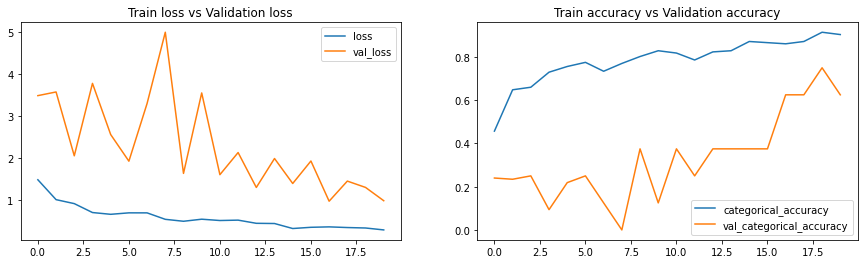

Max. Training Accuracy 0.9144384860992432
Max. Validaiton Accuracy 0.75


In [23]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

plotModelHistory(model1_history)

# Transfer Learning (VGG16) with LSTM

In [16]:
vgg16 = VGG16(weights='imagenet', include_top=False)

n_frames = 20
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model3 = Sequential([
    TimeDistributed(vgg16, input_shape=inputShape)
], name="vgg16_lstm")

for layer in model3.layers:
    layer.trainable = False

model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model3.add(TimeDistributed(Flatten()))

model3.add(LSTM(256))
model3.add(Dropout(0.2))

model3.add(Dense(256,activation='relu'))
model3.add(Dropout(0.2))

model3.add(Dense(5, activation='softmax'))

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model3.summary())

model3_history = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "vgg16_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 3, 3, 512)    14714688  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 3, 3, 512)    2048      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 1, 1, 512)    0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 512)          0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 256)               7

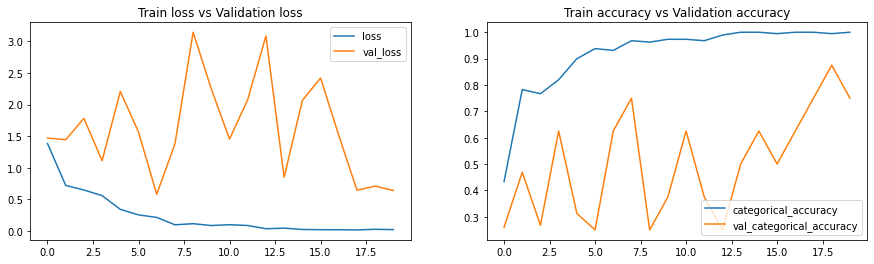

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.875


In [18]:
plotModelHistory(model3_history)

# Transfer Learning (MobileNet) with LSTM

In [27]:
from tensorflow.keras.applications import mobilenet

In [28]:
mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)

n_frames = 20
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model7 = Sequential([
    TimeDistributed(mobilenet, input_shape=inputShape)
], name="mobilenet_lstm")

for layer in model7.layers:
    layer.trainable = False

model7.add(TimeDistributed(BatchNormalization()))
model7.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model7.add(TimeDistributed(Flatten()))

model7.add(LSTM(256))
model7.add(Dropout(0.2))

model7.add(Dense(256,activation='relu'))
model7.add(Dropout(0.2))

model7.add(Dense(5, activation='softmax'))

model7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model7.summary())

model7_history = model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "mobilenet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 20, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 20, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 1024)         0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 256)            

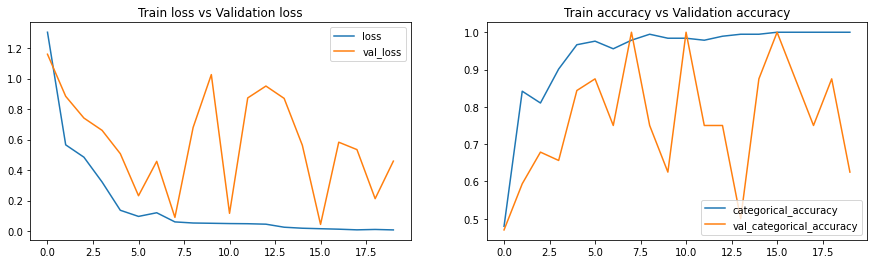

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 1.0


In [30]:
plotModelHistory(model7_history)